## Matrix multiplication from foundations

The *foundations* we'll assume throughout this course are:
- Jupyter notebooks and nbdev
- Python with its standard library
- matplotlib

After we implemented something correctly using only the above foundations, we can then start using another library implementation.

In [1]:
from pathlib import Path
#import pickle, gzip, math, os, time, shutil, matplotlib as mpl, matplotlib.pyplot as plt

## Get data
[MNIST database](https://en.wikipedia.org/wiki/MNIST_database)

In [2]:
MNIST_URL='https://github.com/mnielsen/neural-networks-and-deep-learning/blob/master/data/mnist.pkl.gz?raw=true'
path_data = Path('data')
path_data.mkdir(exist_ok=True)
path_gz = path_data/'mnist.pkl.gz'

[urlretrieve](https://docs.python.org/3/library/urllib.request.html#urllib.request.urlretrieve) - (read the docs!)
<br>
 urllib.request.urlretrieve(url, filename=None, reporthook=None, data=None)

Copy a network object denoted by a URL to a local file. If the URL points to a local file, the object will not be copied unless filename is supplied. Return a tuple (filename, headers) where filename is the local file name under which the object can be found, and headers is whatever the info() method of the object returned by urlopen() returned (for a remote object). 

In [3]:
from urllib.request import urlretrieve
if not path_gz.exists(): urlretrieve(url=MNIST_URL, filename=path_gz)

In [4]:
ls -l {path_data}"/" # data/

total 33312
-rw-r--r--  1 germangoldszmidt  staff  17051982 Apr 17 17:50 mnist.pkl.gz


This is a gzip file, Python has a [gzip module](https://docs.python.org/3/library/gzip.html), so we can open a gzip file using `gzip.open()`. 
We pass the path, the `rb` means read it as binary, —as opposed to text—. 
A Context Manager `with` block can do different things.
Here it is going to open the file and the gzip object will be called `f`.
Then it runs everything inside the block and when it's done it  will close the file automatically. 

The gzip file contains a `pickle` (.pkl) object, a Python object saved to disk. 
It's the main way in pure Python to save stuff and it's part of the standard library.
`pickle.load()` to load from that file. 

In [5]:
import gzip, pickle
with gzip.open(path_gz, 'rb') as f:
    ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding='latin-1')

The MNIST file contains 3  tuples.
When we put a tuple on the left hand side of an equal sign it allows us to "destructure" it.
It puts the 1st tuple into `x_train` and `y_train`, and the second tuple into `x_valid` and `y_valid`. 

Unfortunately the content comes as NumPy.

In [6]:
type(x_train)

numpy.ndarray

Per our rules, we are not allowed to use NumPy, so we turn the first image `x_train[0]` into a list, `lst1`, which has 784 items (28x28 pixels).

In [7]:
lst1 = list(x_train[0])
len(lst1)

784

To learn about a new data set, we grab a piece and look at it to get a sense of what it is.
Below are a few examples of some values in that list.

In [8]:
vals = lst1[200:210]
vals

[np.float32(0.0),
 np.float32(0.0),
 np.float32(0.0),
 np.float32(0.19140625),
 np.float32(0.9296875),
 np.float32(0.98828125),
 np.float32(0.98828125),
 np.float32(0.98828125),
 np.float32(0.98828125),
 np.float32(0.98828125)]

Looks like they're numbers between 0 and 1. But they are in numpy so we map them to `float`

In [9]:
vals = list(map(float, vals)); vals

[0.0,
 0.0,
 0.0,
 0.19140625,
 0.9296875,
 0.98828125,
 0.98828125,
 0.98828125,
 0.98828125,
 0.98828125]

### Generators and iterators

In [10]:
some_dict = {'a': 1, 'b': 2, 'c': 3}
dict_iterator = iter(some_dict)
list(dict_iterator)

['a', 'b', 'c']

The [yield](https://docs.python.org/3/reference/expressions.html#yieldexpr) in Python is similar to a return statement.
Whereas `return` simply returns a value, `yield` returns a **generator object** (to the caller of the function which contains `yield`).

In [11]:
def squares(n=10):
    print('Generating squares from 1 to {0}'.format(n ** 2)) 
    #above {0} is a placeholder used in string formatting, typically with the .format() method.
    for i in range(-10, n + 1):
        yield i ** 2

gen = squares(21)
for x in gen:
    print(x, end=' ')

Generating squares from 1 to 441
100 81 64 49 36 25 16 9 4 1 0 1 4 9 16 25 36 49 64 81 100 121 144 169 196 225 256 289 324 361 400 441 

How do we turn the 784 long list into a 28 by 28? 
We want a list of 28 lists of 28 items each, because we don't yet have matrices.
Lets define a function `chunks` to do it. 

In [12]:
def chunks(x, sz):
    for i in range(0, len(x), sz): yield x[i:i+sz]

`vals` is currently a list of 10 things. 
`chunks(vals, 5)` creates two lists of 5. 
It's  "chunkifying" this list and 5 is the length of each chunk. 

In [13]:
len(vals)

10

In [14]:
list(chunks(vals, 5))

[[0.0, 0.0, 0.0, 0.19140625, 0.9296875],
 [0.98828125, 0.98828125, 0.98828125, 0.98828125, 0.98828125]]

Now we can take the full image `lst1`, 
chunkify it into chunks of 28 long, turn it into a list, and plot it.

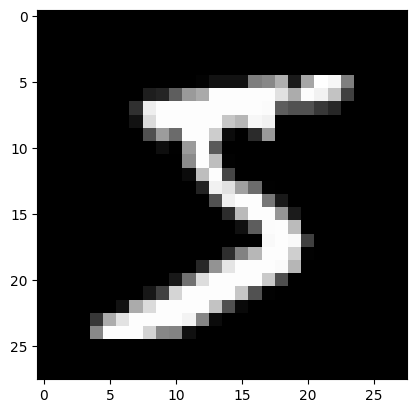

In [15]:
import matplotlib as mpl, matplotlib.pyplot as plt
mpl.rcParams['image.cmap'] = 'gray'
plt.imshow(list(chunks(lst1, 28)));

Python comes with a standard library “itertools” that makes it easier to work with iterators. 
Lets see one example, [islice](https://docs.python.org/3/library/itertools.html#itertools.islice).
`.islice(iterable, start, stop[, step])`
<sup><sub>Make an iterator that returns selected elements from the iterable. If start is non-zero, then elements from the iterable are skipped until start is reached. Afterward, elements are returned consecutively unless step is set higher than one which results in items being skipped. If stop is None, then iteration continues until the iterator is exhausted, if at all; otherwise, it stops at the specified position.</sub></sup>

In [16]:
from itertools import islice  

Lets create an *iterator* `it` and then call `next(it)` a few times. 
We pass the 10 value list `vals` to `iter()` to turn `it` into an iterator.
Because `it` is an iterator, calling `next(it)` returns each item, one at a time.

In [17]:
it = iter(vals)
for i in range(len(vals)): print(next(it))

0.0
0.0
0.0
0.19140625
0.9296875
0.98828125
0.98828125
0.98828125
0.98828125
0.98828125


`islice()` converts `isit` into a different kind of iterator.
```
islice(iterable, stop) --> islice object
islice(iterable, start, stop[, step]) --> islice object
```
Return an iterator whose next() method returns only `stop` items, e.g., the first five, 
before it raises `StopIteration`.   

In [18]:
it = iter(vals)
isit = islice(it, 5)

We pass it to `list()`, shows that the iterator grabbed the first 5 items, so after the 1st call it's up to the sixth item.

In [19]:
list(islice(it, 5))

[0.0, 0.0, 0.0, 0.19140625, 0.9296875]

We call it again and get the next five items.

In [20]:
list(islice(it, 5))

[0.98828125, 0.98828125, 0.98828125, 0.98828125, 0.98828125]

and if we call it again, then there's nothing left.

In [21]:
list(islice(it, 5))

[]

In [22]:
def f(): return list(islice(it, 28))
it = iter(vals)
islice(it, 5)

In [23]:
f()

[0.0,
 0.0,
 0.0,
 0.19140625,
 0.9296875,
 0.98828125,
 0.98828125,
 0.98828125,
 0.98828125,
 0.98828125]

Lets do "chunks" with `islice`.
To `iter`  we can pass a list (to create an iterator) or we can pass it  a “callable”. 
A callable is something that we can put parentheses `()` after, e.g., a function, a class, etc.
Below we pass it a (lambda) function and, in the second form, 
it's going to be called until the function returns `[]`, empty list. 
And `islice` will return empty list when it's done.  
<br>
Below will keep calling the function again until it gets an empty list. Using 28 we get our image again. 

In [24]:
it = iter(lst1)
it2 = iter(lambda: list(islice(it, 28)), [])
img = list(it2)

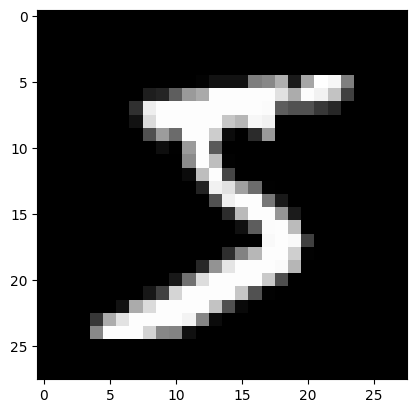

In [25]:
plt.imshow(img);

We have two different ways of creating the same thing.  

### Playing with iterators
`lambda`s are functions defined inline.
Let's replace the above `lambda` with a function `f()` and experiment.  So let's create our iterator, `it`.

In [26]:
lst1 = list(map(float, lst1))

In [27]:
def f(): return(list(islice(it, 28)), [])
it= iter(lst1)

then call `f()` on it, and it returns the first 28, and each subsequent call will return another 28.  

In [28]:
f()    # call multiple times to get many values.

([0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0],
 [])

## Matrix and tensor

`img` is a list of lists, and each list is 28 long.
We can index into it, e.g., `img[20]`, is a list of 28 numbers. 

In [29]:
type(img), type(img[0])

(list, list)

In [30]:
len(img[20])

28

We can index into it, `image[20][15]`, but for matrices, we would rather write it as `M[i, j]`.
For this, we have to define our own class.  

In [31]:
img[20][15]

np.float32(0.98828125)

In [32]:
img = [[float(item) for item in sublist] for sublist in img]
img[20][15]

0.98828125

### Class 
To create a class in Python, we write “class”  and then write the name of it. 
Then we need to write "dunder" methods, with names of two \__ (underscores), a special word, and then two \__ , e.g.`__init__`.
Dunder methods are special methods which have particular meanings to Python,
all documented in the [Python data model](https://docs.python.org/3/reference/datamodel.html).
<br>
We want to be  able to call `img[20,15]`. 
As part of the Python data model, there is `__getitem__`.   
When we call square brackets `[]` on an object, `__getitem__` is what Python uses. 
It passes the e.g., `[20,15]` as indices `idxs`.   So we `return self.xs[idxs[0]][idxs[1]]` , with the first index and the second index.   

In [33]:
class Matrix:
    def __init__(self, xs): self.xs = xs
    def __getitem__(self, idxs): return self.xs[idxs[0]][idxs[1]]

So let's create that Matrix class and run that and check that `m[20,15]` is the same as `img[20][15]`  above.

In [34]:
%time
m = Matrix(img)
m[20,15]

CPU times: user 1 μs, sys: 0 ns, total: 1 μs
Wall time: 2.15 μs


0.98828125

### Tensor
Now that we've created something that lets us index into things, we're allowed to use this one feature from Pytorch.   
To create a  tensor like our `Matrix`, we can pass a list into `tensor()` to get back a tensor version of that list.

In [35]:
import torch
from torch import tensor

Pytorch documentation is not great.
[tensor](https://pytorch.org/docs/stable/tensors.html)s do everything for numeric programming. 
It's worth scrolling through the docs to get a general sense.
*"A torch.Tensor is a multi-dimensional matrix containing elements of a single data type. 
...."*
<br>
This is how we constructed one before, passing it list of lists. 
We can also pass it NumPy arrays, change types, etc.
**NB:** Eventually we want to know every single method, at least be aware of what exists so we know what to search for in the docs.
Otherwise we end up recreating stuff from scratch, which is slower than reading the documentation to find out it's there.

In [36]:
tensor([1,2,3])

tensor([1, 2, 3])

More interestingly, we can pass in a list of lists, e.g., `img`.  

In [37]:
%time
tens = tensor(img)
tens[20,15]

CPU times: user 1 μs, sys: 0 ns, total: 1 μs
Wall time: 1.91 μs


tensor(0.9883)

Since we've successfully "implemented" that functionality we can now convert all our lists into tensors.
A convenient way is  Python's `map()` function, which takes a function `f` and one or more iterables, (in this case one iterable,) applies `f` (e.g., `tensor`) to the four `x_ , y_` variables, and returns 4 results.
Below it is converting the 4 lists to tensors and storing them back with the same name.

In [38]:
x_train,y_train,x_valid,y_valid = map(tensor, (x_train,y_train,x_valid,y_valid))
x_train.shape

torch.Size([50000, 784])

`x_train` now is a tensor, so it has a `.shape` property: 
it has  50,000 images each 784 long. 
We can find out what kind of elements it contains by calling `.type()`. 

In [39]:
x_train.type()

'torch.FloatTensor'

Instead of chunks, or  islice, the `reshape` method is roughly equivalent in a tensor.
To reshape our 50,000 by 784 tensor into 50,000 28 by 28 tensors, we write `.reshape(50000, 28, 28)`.  
Or, we can use `-1` which means just fill this with all the rest, i.e., it can figure out that must be 50000. 

In [40]:
imgs = x_train.reshape((-1,28,28))   #-1 means figure it out by yourself
imgs.shape, imgs.ndim

(torch.Size([50000, 28, 28]), 3)

`imgs` is a batch of 50,000 28x28 images, and a rank-3 tensor in Pytorch.
NumPy would call it an array with 3 dimensions. 
The rank is the number of dimensions given by `ndim`.
Each image is a matrix, a 28 by 28 rank-2 tensor.
A vector is a rank-1 tensor, a scalar is a rank-0 tensor.
Many languages/libraries don't do it that way, so a scalar is dependent on the language.

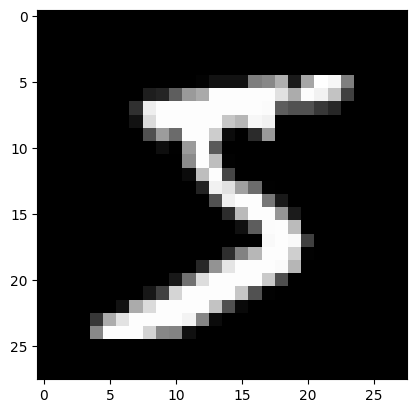

In [41]:
plt.imshow(imgs[0]);

We can index into the 0th image, 20th row, 15th column to get back the same value.  

In [42]:
imgs[0,20,15]

tensor(0.9883)

In [43]:
x_train.shape

torch.Size([50000, 784])

We can take `x_train.shape` and destructure it into `n`, number of images, and `p`, number of pixels. 

In [44]:
n,p = x_train.shape
n, p

(50000, 784)

`y_train` is going to have the labels, in this case the corresponding digits.  Its `.shape` indicates there are 50,000 labels.

In [45]:
y_train, y_train.shape

(tensor([5, 0, 4,  ..., 8, 4, 8]), torch.Size([50000]))

`min()` and `max()` are part of the library, so we can find out what are the smallest and largest digit numbers. 

In [46]:
min(y_train),max(y_train)

(tensor(0), tensor(9))

They go from 0 to 9, and are scalar tensors.  Notice 2 ways to invoke these functions.

In [47]:
y_train.min(), y_train.max()

(tensor(0), tensor(9))

## Matrix multiplication

In the final layer of a NeuralNet, for a MNIST digits linear classifier, the linear weights need to be 784x10,
because that's the number of possible outputs, the number of possible digits.
Below we create a 784x10 Matrix, `weights`, and assign it random numbers.
For the `bias`, what we're going to add to each one, we use 0s to start.

In [48]:
weights = torch.randn(784,10)
bias = torch.zeros(10)
weights, bias

(tensor([[ 0.0414,  0.1635, -0.4044,  ..., -0.0850, -0.9189, -0.6654],
         [-0.2287, -0.7262,  0.5672,  ...,  0.6683, -1.5478, -2.1764],
         [-1.1729,  0.6536, -0.4078,  ..., -0.0367, -0.5575, -1.3143],
         ...,
         [-0.1857, -0.0951, -1.2352,  ...,  0.6356,  0.8468,  0.5517],
         [-0.8920, -0.7130,  2.0665,  ..., -0.5454, -0.3429, -0.1713],
         [ 0.0526,  1.6330,  0.8050,  ...,  0.1782,  1.4491,  0.7351]]),
 tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]))

Lets use a subset of MNIST, a matrix `m1`, which has the first five handwritten digits. 

In [49]:
m1 = x_valid[:5]
m2 = weights

For matrix multiplication, we do a little minibatch, 5 rows of images flattened out,
and then multiply by the `m2` weights matrix. 

In [50]:
m1.shape,m2.shape

(torch.Size([5, 784]), torch.Size([784, 10]))

The shapes are: `m1` is 5x784, `m2` is 784x10. 
We deconstruct the shapes into variables `ar, ac, br, bc`.

In [51]:
ar,ac = m1.shape # n_rows * n_cols
br,bc = m2.shape
(ar,ac),(br,bc)

((5, 784), (784, 10))

The resultant tensor `t1` (where each item is the result of multiplying together the corresponding 784 pairs and adding them up), will be 5x10 (`ar`x`bc`). 
`t1` starts with zeros. 

In [52]:
t1 = torch.zeros(ar, bc)
t1.shape

torch.Size([5, 10])

To fill `t1` we have to go  through each `ar` row (of `m1`), one at a time, then through each `bc` column, one at a time,
and then through each pair in that row column one at a time. 
Its a loop in a loop in a loop. 
The result for the `i` row and the `j` column, we add onto it the product of `i, k` in the  first matrix, by `k, j` in the second matrix. 
So `k` is going up through those 784, across the rows and down the columns. 
This is a naive, slow, uninteresting matrix multiplication method. 

In [53]:
%time
for i in range(ar):         # 5
    for j in range(bc):     # 10
        for k in range(ac): # 784
            t1[i,j] += m1[i,k] * m2[k,j]

CPU times: user 2 μs, sys: 0 ns, total: 2 μs
Wall time: 1.19 μs


In [54]:
t1.shape, type(t1)

(torch.Size([5, 10]), torch.Tensor)

In [55]:
t1

tensor([[  5.6027,   6.7301, -25.6139,   6.2740,  -9.1184,  -3.1055,   4.0020,
          12.4135, -10.5522,   7.5918],
        [  1.5410,  -0.9061, -10.8469,   1.8002,   3.2709,   1.8615,   8.5715,
           3.7556,   4.0554,   2.4449],
        [  2.3159,  -9.8328,  -5.4348, -11.9813,  -9.6587,   0.7665,  10.4471,
           5.4064,   8.3007,   2.5606],
        [  4.0992,  -0.1402,   5.7697,   4.3643, -16.4050,   0.7321,  -4.7187,
         -11.8572,  -9.7496, -13.0110],
        [  6.6885,   2.5830,  -3.7286,   2.0862,  -4.3734,  -8.2773,  -3.6511,
         -14.9864,   1.4023,   1.4318]])

Above output is hard to read because it assumes/defaults the screen size to 80 columns wide.
We change it with `set_print_options`, and choose line width 140. 
(NB: put these settings at the top of notebooks, both for torch and NumPy.)

In [56]:
import numpy as np
torch.set_printoptions(precision=2, linewidth=140, sci_mode=False)   # make it easier to read
np.set_printoptions(precision=2, linewidth=140)
t1

tensor([[  5.60,   6.73, -25.61,   6.27,  -9.12,  -3.11,   4.00,  12.41, -10.55,   7.59],
        [  1.54,  -0.91, -10.85,   1.80,   3.27,   1.86,   8.57,   3.76,   4.06,   2.44],
        [  2.32,  -9.83,  -5.43, -11.98,  -9.66,   0.77,  10.45,   5.41,   8.30,   2.56],
        [  4.10,  -0.14,   5.77,   4.36, -16.41,   0.73,  -4.72, -11.86,  -9.75, -13.01],
        [  6.69,   2.58,  -3.73,   2.09,  -4.37,  -8.28,  -3.65, -14.99,   1.40,   1.43]])

Check that the multiplication is correct, `@` does exactly  the same things we just did.  

In [57]:
s1 = m1 @ m2
s1.shape, type(s1)

(torch.Size([5, 10]), torch.Tensor)

Below shows we have successfully multiplied the matrices `m1` and `m2`. 

In [58]:
s1[0], t1[0]

(tensor([  5.60,   6.73, -25.61,   6.27,  -9.12,  -3.11,   4.00,  12.41, -10.55,   7.59]),
 tensor([  5.60,   6.73, -25.61,   6.27,  -9.12,  -3.11,   4.00,  12.41, -10.55,   7.59]))

We work step by step in Jupyter, and then once it is working, copy all the cells and paste them.
Select them  with shift+M to merge, get rid of prints that we don't need. 
Then add a header on the  top, give it a function name, and turn it into a function. 
We still keep the stuff above it, so we can see the step by step stuff for learning about it later.  

In [59]:
def matmul(a,b):
    (ar,ac),(br,bc) = a.shape,b.shape
    assert(ac==br)
    c = torch.zeros(ar, bc)
    for i in range(ar):
        for j in range(bc):
            for k in range(ac): c[i,j] += a[i,k] * b[k,j]
    return c

In [60]:
ar*ac*bc # Total number of multiplications... how long it took?

39200

We use %time and see how long it took to generate a small matrix, just five MNIST digits. 
We need to speed that up.

In [61]:
%time _=matmul(m1, m2) 

CPU times: user 163 ms, sys: 2.01 ms, total: 165 ms
Wall time: 164 ms


## Numba
[Numba](https://numba.pydata.org/numba-doc/latest/user/5minguide.html) is a just-in-time compiler for Python that works best on code that uses NumPy arrays and functions, and loops. The common way to use Numba is through its collection of decorators that can be applied to functions to instruct Numba to compile them. When a call is made to a Numba decorated function it is compiled to machine code “just-in-time” for execution.
Numba takes Python and compiles it into machine code, and also CUDA code.
We must enable the cuda simulator with an environment variable `'NUMBA_ENABLE_CUDASIM'='1'` BEFORE loading numba.

In [62]:
if not(torch.cuda.is_available()):
    import os
    os.environ['NUMBA_ENABLE_CUDASIM']='1'

In [63]:
from numba import njit

We write @njit above the function definition. The first time we call the function it compiles it to machine code, afterwards
it will run much more quickly. 

`dot` is just the inermost loop: for 2 vectors `a,b`, start at `res=0`, go through the `len(a)` and add up all the `a[i]*[b[i]`and return `res`.
(a dot product in linear algebra).

In [64]:
@njit
def dot(a,b):
    res = 0.
    for i in range(len(a)): res+=a[i]*b[i]
    return res

NB: Numba only works with  NumPy, doesn't work with PyTorch.  

In [65]:
from numpy import array

Lets do a `dot` product of 1, 2, 3 and 2, 3, 4.
It will take a longer time, because it is going to compile and run it. 

In [66]:
%time dot(array([1.,2,3]),array([2.,3,4]))

CPU times: user 156 ms, sys: 30 ms, total: 186 ms
Wall time: 283 ms


20.0

Now that it's compiled, the second time, it's just microseconds. 

In [67]:
%time dot(array([1.,2,3]),array([2.,3,4]))

CPU times: user 9 μs, sys: 0 ns, total: 9 μs
Wall time: 10 μs


20.0

If we replace the core loop in Python with a call to `dot`, (now compiled), then we have only 2 loops running "in Python". 

In [68]:
def matmul(a,b):
    (ar,ac),(br,bc) = a.shape,b.shape
    c = torch.zeros(ar, bc)
    for i in range(ar):
        for j in range(bc): c[i,j] = dot(a[i,:], b[:,j])
    return c

In [69]:
m1a,m2a = m1.numpy(),m2.numpy()

%timeit -n 10 matmul(m1a,m2a)

The slowest run took 19.62 times longer than the fastest. This could mean that an intermediate result is being cached.
360 μs ± 639 μs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [70]:
%time _ = matmul(m1a,m2a);

CPU times: user 404 μs, sys: 399 μs, total: 803 μs
Wall time: 467 μs


Now it is 2 orders of magnitude faster, by changing the one innermost loop with an @njit compiled version.

In [71]:
from fastcore.test import test_close

We need to test that the results are close.
Fastcore's `test_close()` checks that 2 things are "very close", i.e. difference < `eps`. 
They might not be exactly the same because of floating point differences. 
`matmul` is working correctly, (or at least it's doing the same thing it did before).  

In [72]:
test_close(t1,matmul(m1a, m2a),eps=1e-3)

## Elementwise ops

Many say that learning [APL](https://aplwiki.com/wiki/Main_Page) taught them more about programming than anything. So consider learning APL, eg [TryAPL](https://tryapl.org/). 
We can do similar things in PyTorch but it is more verbose.
JH likes to do mathematical fiddling in APL, with less boilerplate, more time thinking, see everything on the screen at once.
No waste of time trying to ignore the Python cognitive load, e.g., tensor around bracket, square bracket, dot comma, etc.

In [73]:
a = tensor([10., 6, -4])
b = tensor([2., 8, 7])
a,b

(tensor([10.,  6., -4.]), tensor([2., 8., 7.]))

We can say a + b and it works like in APL.

In [74]:
a + b

tensor([12., 14.,  3.])

The `<` operates element wise. 
`a < b` means: 10 is less than 2, 6 is less than 8, 4 is less than 7 and gives us back
each of those `True` and `False`. 

In [75]:
(a < b)

tensor([False,  True,  True])

`True` and `False` are represented by 1 and 0, so we can use them for math, e.g., we can add them and subtract them. 

In [76]:
(a < b).float().mean()

tensor(0.67)

Higher rank, `m` is a rank-2 tensor, a matrix.

In [77]:
m = tensor([[1., 2, 3], [4,5,6], [7,8,9]]); m

tensor([[1., 2., 3.],
        [4., 5., 6.],
        [7., 8., 9.]])

We will use the **Frobenius** norm in generative modeling: 
Take all the elements of a matrix, square them, add them up and take the square root. 
The Frobenius norm is an extension of the Euclidean norm to $K^{n × n}$. 

Frobenius norm :
$$\| A \|_F = \left( \sum_{i,j=1}^n | a_{ij} |^2 \right)^{1/2}$$
*Hint*: To write equations in LaTeX you can click 'edit' in Wikipedia and copy the LaTeX from there. Or on arxiv.org, click "Download: Other formats" in the top right, then "Download source"; rename the downloaded file to end in `.tgz` if it doesn't already, and the source includes the equations to copy and paste. This is the source LaTeX that renders the equation above:
```latex
$$\| A \|_F = \left( \sum_{i,j=1}^n | a_{ij} |^2 \right)^{1/2}$$
```

In PyTorch is as follows:  

In [78]:
(m*m).sum().sqrt()   #Frobenius norm of m

tensor(16.88)

We index into a  matrix, rows first and then columns. 
`m[2,:]` means all the columns of row 2, and `m[:,-1]` are all the the rows of the last column.
We use `,` to print out multiple things, (no need to say print in Jupyter, its assumed). 

In [79]:
m[2,:], m[:,-1]

(tensor([7., 8., 9.]), tensor([3., 6., 9.]))

For tensors of higher rank than 1, such as a matrix, any trailing colons are optional. 
`m[2]` is the same as `m[2, :]`. 

In [80]:
m[2]

tensor([7., 8., 9.])

Lets get rid of the innermost loop (`k`), as it is multiplying together 
all the `k` columns of `a` with the corresponding `k` rows of a column of `b`. 
We can use element wise operation: `a[i,:] * b[:,j]`

In [81]:
def matmul(a,b):
    (ar,ac),(br,bc) = a.shape,b.shape
    c = torch.zeros(ar, bc)
    for i in range(ar):
        for j in range(bc): c[i,j] = (a[i,:] * b[:,j]).sum()
    return c

In [82]:
test_close(t1,matmul(m1, m2))

In [83]:
%timeit -n 10 _=matmul(m1, m2)

220 μs ± 11.9 μs per loop (mean ± std. dev. of 7 runs, 10 loops each)


It is slower than the Numba compiled code, but faster than our naive first attempt.
And we're using something that is  more general now, the same as `dot`.
Now we can use `torch.dot()`, which is a little faster, but still slower than the Numba.

In [84]:
def matmul(a,b):
    (ar,ac),(br,bc) = a.shape,b.shape
    c = torch.zeros(ar, bc)
    for i in range(ar):
        for j in range(bc): c[i,j] = torch.dot(a[i,:], b[:,j])
    return c

In [85]:
test_close(t1,matmul(m1, m2),eps=1e-4)

In [86]:
%timeit -n 10 _=matmul(m1, m2)

181 μs ± 11.6 μs per loop (mean ± std. dev. of 7 runs, 10 loops each)


## Broadcasting - how arrays with different shapes are treated during arithmetic operations. 

From the [Numpy Documentation](https://docs.scipy.org/doc/numpy-1.10.0/user/basics.broadcasting.html):

The term **broadcasting** describes how numpy treats arrays with different shapes during arithmetic operations. 
Subject to certain constraints, the smaller array is “broadcast” across the larger array so that they have compatible shapes. Broadcasting provides a means of vectorizing array operations so that looping occurs in C instead of Python. 
It does this without making needless copies of data and usually leads to efficient algorithm implementations.
In addition to the efficiency of broadcasting, it allows developers to write less code, which typically leads to fewer errors.

*This section was adapted from [Chapter 4](http://nbviewer.jupyter.org/github/fastai/numerical-linear-algebra/blob/master/nbs/4.%20Compressed%20Sensing%20of%20CT%20Scans%20with%20Robust%20Regression.ipynb#4.-Compressed-Sensing-of-CT-Scans-with-Robust-Regression) of the fast.ai [Computational Linear Algebra](https://github.com/fastai/numerical-linear-algebra) course.*

### Broadcasting with a scalar

In [87]:
a

tensor([10.,  6., -4.])

In [88]:
a > 0

tensor([ True,  True, False])

How are we able to compare an array with a scalar in `a > 0`? 
The scalar `0` is being **broadcast** to have the same dimensions as the array `a`.

We can using broadcasting to normalize a dataset by subtracting the mean (a scalar) from the entire data set (a matrix) and dividing by the standard deviation (another scalar).
<br>
Other examples of broadcasting with a scalar:

In [89]:
a + 1

tensor([11.,  7., -3.])

In [90]:
m

tensor([[1., 2., 3.],
        [4., 5., 6.],
        [7., 8., 9.]])

In [91]:
2*m

tensor([[ 2.,  4.,  6.],
        [ 8., 10., 12.],
        [14., 16., 18.]])

### Broadcasting a vector to a matrix
Broadcasting a scalar dates back to APL, but the idea of broadcasting **across higher rank tensors** [comes from](https://mail.python.org/pipermail/matrix-sig/1995-November/000143.html) the language [Yorick](https://software.llnl.gov/yorick-doc/manual/yorick_50.html).

#### We can broadcast a vector to a matrix:

In [92]:
c = tensor([10.,20,30]); c

tensor([10., 20., 30.])

In [93]:
m

tensor([[1., 2., 3.],
        [4., 5., 6.],
        [7., 8., 9.]])

In [94]:
m.shape,c.shape

(torch.Size([3, 3]), torch.Size([3]))

Instead of broadcasting a scalar over a  higher rank tensor, `m + c` broadcasts a vector `c` across every row of a matrix `m`. 

In [95]:
m + c

tensor([[11., 22., 33.],
        [14., 25., 36.],
        [17., 28., 39.]])

And it is commutative, i.e., `(m+c)==(c+m)`.  

In [96]:
c + m

tensor([[11., 22., 33.],
        [14., 25., 36.],
        [17., 28., 39.]])

It doesn't copy the rows, but it looks as it did. In fact, the rows are given a *stride* of 0.

#### expand_as()
`t=c.expand_as(m)` creates a new Tensor `t`, with the same content as `c`, but expanded so it has the same shape as `m`. 
Below, `t` will contains 3 copies of `c`. 

In [97]:
t = c.expand_as(m)
t

tensor([[10., 20., 30.],
        [10., 20., 30.],
        [10., 20., 30.]])

And we can add `t` to `m` because they match shapes. 

In [98]:
m + t

tensor([[11., 22., 33.],
        [14., 25., 36.],
        [17., 28., 39.]])

`expand_as()` didn't  create three copies. 
`expand_as()` does not create a new tensor with copied data. Instead, it returns a view of the original tensor, with expanded dimensions (using broadcasting), without allocating new memory.

In [99]:
print("Original m:")
print("Shape:", m.shape)
print("Strides:", m.stride())

print("\nExpanded t:")
print("Shape:", t.shape)
print("Strides:", t.stride())


Original m:
Shape: torch.Size([3, 3])
Strides: (3, 1)

Expanded t:
Shape: torch.Size([3, 3])
Strides: (0, 1)


But `t` has a *stride of 0* across the  rows and a size of `[3, 3]`, so it acts as a 3 by 3 matrix. 
Each time it "goes" to the next row, it stays where it is. 
Strides is the trick which NumPy and PyTorch use to create efficient ways to do things
like expanding, jump over things, switch between columns and rows.
We didn't make a copy, it is efficient and it's going to run in C code fast.  
`expand_as()` is critical to understand how broadcasting works.

To convert a 1-dimensional array into a 2-dimensional array (although one of those dimensions has value 1)
we can index with the special value `None` or use `unsqueeze()`. 
`c` is  a vector containing `[10, 20, 30]`, then `c.unsqueeze(0)`, changes the shape from `[3]` to `[1,3]`. 
From a vector of length 3 to a matrix of 1 row by 3 columns.
Notice it's printed, with two square brackets `[[ .... ]]` to indicate two dimensions. 

In [100]:
c.unsqueeze(0), c[None, :]

(tensor([[10., 20., 30.]]), tensor([[10., 20., 30.]]))

In [101]:
c.shape, c.unsqueeze(0).shape

(torch.Size([3]), torch.Size([1, 3]))

`unsqueeze(1)` means to unsqueeze into the first dimension, i.e., we now have 3 rows and 1 column. 

In [102]:
c.unsqueeze(1), c[:, None]

(tensor([[10.],
         [20.],
         [30.]]),
 tensor([[10.],
         [20.],
         [30.]]))

In [103]:
c.shape, c.unsqueeze(1).shape

(torch.Size([3]), torch.Size([3, 1]))

We can do the same thing here, give us every row and a new unit axis in position 1.
`c[None]` creates a matrix with 1 row, and `c[...,None]` creates a matrix with 1 column.
We can always skip trailling ':'s. And '...' means '*all preceding dimensions*'.

In [104]:
c[None].shape,c[...,None].shape

(torch.Size([1, 3]), torch.Size([3, 1]))

Let's check out what `c[:, None]` looks like: it is a column. 

In [105]:
c[:, None]

tensor([[10.],
        [20.],
        [30.]])

with `.expand_as(m)`, which is 3 by 3, it is going to take that column and replicate it. 

In [106]:
c[:,None].expand_as(m)

tensor([[10., 10., 10.],
        [20., 20., 20.],
        [30., 30., 30.]])

To add a matrix to m, we don't need to say `.expand_as()`, we just  write `m + c[:, None]`,
which does `.expand_as()` for us. 

In [107]:
m + c[:,None]

tensor([[11., 12., 13.],
        [24., 25., 26.],
        [37., 38., 39.]])

Below is the same as doing `m + c`,  but now rather than adding the vector to each row, it's adding the vector to each column. 

In [108]:
m + c[None,:]

tensor([[11., 22., 33.],
        [14., 25., 36.],
        [17., 28., 39.]])

### Broadcasting Rules

In [109]:
c[None,:]

tensor([[10., 20., 30.]])

In [110]:
c[None,:].shape

torch.Size([1, 3])

In [111]:
c[:,None]

tensor([[10.],
        [20.],
        [30.]])

In [112]:
c[:,None].shape

torch.Size([3, 1])

What are  the rules and how does it work?  `c[None, :]` is 1x3. `c[:, None]` is 3x1. 
`c[None, :] *  c[:, None]` takes the `[10, 20, 30]` column vector (or 3x1 matrix), and will make it work across each of the rows. 
It expands it to be `[10, 20, 30; 10, 20, 30; 10, 20, 30.]`
And then does the same expansion for `c[None, :]`, which becomes 3 rows of `[10, 20, 30]`. 
We have 3 rows times 3 columns, which gives the answer below. 
This is an **outer product**, without any special functions, just using broadcasting. 

In [113]:
c[None,:] * c[:,None]

tensor([[100., 200., 300.],
        [200., 400., 600.],
        [300., 600., 900.]])

We can do **outer Boolean** operations, e.g., below is showing us all the places where it's greater than `>`. 

In [114]:
c[None] > c[:,None]

tensor([[False,  True,  True],
        [False, False,  True],
        [False, False, False]])

When operating on two arrays/tensors, Numpy/PyTorch compares their shapes element-wise. It starts with the **trailing dimensions**, and works its way forward. Two dimensions are **compatible** when
- they are equal, or
- one of them is 1, in which case that dimension is *broadcasted* to make it the same size as the other

*Arrays do not need to have the same number of dimensions.* For example, given `Image`, a `256x256x3` array of RGB values, to scale each color in the image by a different value, multiply `Image` by `Scale` a one-dimensional array with 3 values. Lining up the sizes of the trailing axes of these arrays according to the broadcast rules, shows that they are compatible:

    Image  (3d array): 256 x 256 x 3
    Scale  (1d array):             3
    Result (3d array): 256 x 256 x 3

The [numpy documentation](https://docs.scipy.org/doc/numpy-1.13.0/user/basics.broadcasting.html#general-broadcasting-rules) includes several examples of what dimensions can and can not be broadcast together.

## Matmul with broadcasting
We can use broadcasting to speed up our matrix multiplication. 

Below, the single handwritten `digit` `m1[0]` shape is a 784 long vector (of pixels), and the weight matrix `m2` shape is 784x10. 

In [115]:
digit = m1[0]
digit.shape, m2.shape

(torch.Size([784]), torch.Size([784, 10]))

`digit[:, None]` is a 784 by 1 row matrix.

In [116]:
digit[:,None].shape

torch.Size([784, 1])

If we take the [784,1] `digit` and `.expand_as(m2)`, it gets the same shape as `m2` (the weight matrix). 

In [117]:
digit[:,None].expand_as(m2).shape

torch.Size([784, 10])

`expand_as` has *"copied"* the image data (pixels) for `digit` across all of the 10  vectors representing 
the 10 "kind of linear projections" we're doing for our linear model. 
Now we can take `digit[:, None]` and multiply it by the weights `m2`, to get a `[784,10]` shape. 
The `*`  is looping through each of the 10 (784 long) vectors, and for each one of them, it's  multiplying it by this digit. 
That is what we want to do in a matrix multiplication `matmul`. 

In [118]:
(digit[:,None]*m2).shape

torch.Size([784, 10])

In [119]:
def matmul(a,b):
    (ar,ac),(br,bc) = a.shape,b.shape
    c = torch.zeros(ar, bc)
    for i in range(ar):
#       c[i,j] = (a[i,:] * b[:,j]).sum()      # previous version
        c[i]   = (a[i,:,None] * b).sum(dim=0) # broadcast version
    return c

In [120]:
test_close(t1,matmul(m1, m2),eps=1e-4)

In [121]:
%timeit -n 10 _=matmul(m1, m2)

35.5 μs ± 22.9 μs per loop (mean ± std. dev. of 7 runs, 10 loops each)


Computation time went from (~500ms) to < 0.1ms, an over 5000x improvement! We can now run `matmul` on the whole dataset.

In [122]:
tr = matmul(x_train, weights)
tr

tensor([[  3.64,  -7.20, -10.31,  ...,   3.44,  10.34,   0.20],
        [ 10.25,   5.82,  -8.40,  ...,  -9.74,   0.77,  -8.58],
        [  1.99, -12.17,  -8.75,  ...,  -7.76,  -2.45,  -8.94],
        ...,
        [  8.27,  -4.62,  -3.18,  ...,   0.18,   1.49,   7.03],
        [ -3.30,   3.29,   6.81,  ...,   5.63,  -3.52,  -7.65],
        [  0.82,  -5.78,  -8.12,  ...,  -5.02,   5.52,   2.43]])

In [123]:
tr.shape

torch.Size([50000, 10])

In [124]:
%%time 
_=matmul(x_train, weights)

CPU times: user 834 ms, sys: 24.4 ms, total: 858 ms
Wall time: 258 ms


## Einstein summation

[Einstein summation](https://ajcr.net/Basic-guide-to-einsum/) ([einsum](https://numpy.org/doc/stable/reference/generated/numpy.einsum.html)) is a compact representation for combining products and sums in a general way. The key rules are:
- Repeating letters between input arrays means that values along those axes will be multiplied together.
- Omitting a letter from the output means that values along that axis will be summed.

Lets replicate matrix product using an Einstein summation.
Consider, for example, `torch.einsum('ik,kj->ikj', a, b)`.
An arrow `->` separates inputs (left) from outputs (right), and the inputs (`ik` and `kj`) are separated by a `,`.
Letters are names for the dimensions, the number of letters corresponds to the rank. 
The first input matrix `a` (we're multiplying by) has `i` rows and `k` columns, `b`, the second matrix, has `k` rows and `j` columns. 
The operation will return a new rank-3 tensor with `i` faces, `k` rows, and `j` columns. 
We repeat letters between input arrays, e.g., `k` appears in both `ik` and `kj`,  to indicate that values along those axes will be multiplied together.
In this example, each item in each row of `b` will be multiplied by each item down each column of `a` to create the `[i,k,j]` output tensor. 

`m1` is `[5,784]`, `m2` is `[784,10]`, so `i=5`, `k=784` and `j=10`. 

In [125]:
m1.shape, m2.shape

(torch.Size([5, 784]), torch.Size([784, 10]))

We do this torch.einsum and end up with:

In [126]:
mr = torch.einsum('ik,kj->ikj', m1, m2)

mr.shape

torch.Size([5, 784, 10])

The result contains the original 5 rows of m1, the original 10 columns of m2, and for the 784 dimension,
they're all multiplied together, because it's been copied between the two arguments to the einsum.
If we now sum up that over the (784) dimension (axis 1) we get back the original matrix multiply result.  
With this Einstein summation version, we get back the same thing. 
Its taken each of these columns by rows, multiplied them together to get a 5x784x10, 
and then added up that 784 for each one, which is what matrix multiplication does. 

In [127]:
mr.sum(1)

tensor([[  5.60,   6.73, -25.61,   6.27,  -9.12,  -3.11,   4.00,  12.41, -10.55,   7.59],
        [  1.54,  -0.91, -10.85,   1.80,   3.27,   1.86,   8.57,   3.76,   4.06,   2.44],
        [  2.32,  -9.83,  -5.43, -11.98,  -9.66,   0.77,  10.45,   5.41,   8.30,   2.56],
        [  4.10,  -0.14,   5.77,   4.36, -16.41,   0.73,  -4.72, -11.86,  -9.75, -13.01],
        [  6.69,   2.58,  -3.73,   2.09,  -4.37,  -8.28,  -3.65, -14.99,   1.40,   1.43]])

Second rule: if we omit a letter from the output, those values will be (automatically) summed. 
If we remove the `k` in the output, e.g., `ik,kj->ij`, that sum over the `k` dimmension happens automatically. 

In [128]:
torch.einsum('ik,kj->ij', m1, m2)     # automated the sum.

tensor([[  5.60,   6.73, -25.61,   6.27,  -9.12,  -3.11,   4.00,  12.41, -10.55,   7.59],
        [  1.54,  -0.91, -10.85,   1.80,   3.27,   1.86,   8.57,   3.76,   4.06,   2.44],
        [  2.32,  -9.83,  -5.43, -11.98,  -9.66,   0.77,  10.45,   5.41,   8.30,   2.56],
        [  4.10,  -0.14,   5.77,   4.36, -16.41,   0.73,  -4.72, -11.86,  -9.75, -13.01],
        [  6.69,   2.58,  -3.73,   2.09,  -4.37,  -8.28,  -3.65, -14.99,   1.40,   1.43]])

Einstein summation notation takes practice but it is a convenient, effecient way of thinking about what's going on, and can simplify code.  
It doesn't have to be a sum, we don't have to omit any letters when just doing products. 
Lets define `matmul` using `torch.einsum`, and check with `test_close()` that the original result is equal. 

In [129]:
def matmul(a,b): return torch.einsum('ik,kj->ij', a, b)

In [130]:
test_close(tr, matmul(x_train, weights), eps=1e-3)

The einsum takes ~ 9 ms, compared to ~ 900 ms for the full dataset, 100x faster than the fast broadcasting approach.

In [131]:
%timeit -n 1 _=matmul(x_train, weights)   # much faster...

4.4 ms ± 52.3 μs per loop (mean ± std. dev. of 7 runs, 1 loop each)


## Pytorch op `@`

We can use Pytorch's function [`torch.matmul()`](https://pytorch.org/docs/stable/generated/torch.matmul.html) or its shorthand operator `@` directly for matrix multiplication.

In [132]:
test_close(tr, x_train@weights, eps=1e-3)

In [133]:
%timeit -n 1 _=torch.matmul(x_train, weights)

4.36 ms ± 192 μs per loop (mean ± std. dev. of 7 runs, 1 loop each)


## Parallel and CUDA
Let's go faster by using a GPU, and telling the GPU what we want to do in parallel, one at a time.  
We write in pure Python something that works "like a GPU", except it won't be in parallel, so it won't be fast.
First we define a function that calculates just one thing, 
even if many other things are happening at the same time, it won't interact with anything else.
For a matrix multiplication lets define a function which just fills in a single item of the result, e.g., row zero, column zero.
We define a new `matmul(grid, a,b,c)` where we pass in `grid` as the coordinates to fill in.
Inside we destructure them into `i` (row) and `j` (column). 
We check that i and j are inside the bounds of the output matrix `c`. 
We start at `tmp=0` and loop through all of the columns of `a` and all the rows of `b` for `i` and `j`.
At the end assign `tmp` to the corresponding output entry `c[i,j]`. 

In [134]:
def matmul(grid, a,b,c):
    i,j = grid
    if i < c.shape[0] and j < c.shape[1]: #check that i and j are inside the bounds of the output matrix c. 
        tmp = 0. #start at tmp=0 and loop through all of the columns of a and all the rows of b
        for k in range(a.shape[1]): tmp += a[i, k] * b[k, j]
        c[i,j] = tmp

We'll pass it the matrices `m1, m2` we want to  multiply, and a tensor `res` pre-filled with zeros for the results.
We call matmul for location (0, 0), passing the two matrices and `res`, and we get the answer in the cell `[0, 0]`.  

In [135]:
res = torch.zeros(ar, bc)
matmul((0,0), m1, m2, res)
res

tensor([[5.60, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00],
        [0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00],
        [0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00],
        [0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00],
        [0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00]])

We can call this `matmul` rows * columns times, each time with a different grid, in parallel,
because none of the different locations interact with any other location. 
A `kernel` is a piece of code which can calculate (a little piece of) an output on a GPU.   
<br>
We define `launch_kernel()`, pass it the `kernel` function, 
how many rows `grid_x` and columns `grid_y` are in the output grid, and any arguments needed to calculate it.
In Python, `*args` says any additional arguments that you pass are going to be put into an array `args`. 
<br>
`launch_kernel` will use `i` to loop through the rows of `a`, and for each row of `a`, 
will use `j` to loop through the columns of `b`, and call the `kernel`, (e.g., `matmul`), on that grid location.
It will be passing in `m1, m2,` and `res`, as `*args` is going to unpack those and pass them as 3 separate arguments. 

In [136]:
def launch_kernel(kernel, grid_x, grid_y, *args, **kwargs):
    for i in range(grid_x):
        for j in range(grid_y): 
            kernel((i,j), *args, **kwargs)

We call `launch_kernel(matmul, ar, bc, m1, m2, res)` with `ar` all the rows of `a`, 
`bc` all the columns of `b`, and then the `*args`: `m1`, the first matrix, `m2`, the second matrix, 
and `res`, another `torch.zeros`.
The result `res` is the same matrix. 

In [137]:
ar = m1.shape[0]; bc=m2.shape[1]
ar, bc

(5, 10)

In [138]:
res = torch.zeros(ar, bc)
launch_kernel(matmul, ar, bc, m1, m2, res)
res

tensor([[  5.60,   6.73, -25.61,   6.27,  -9.12,  -3.11,   4.00,  12.41, -10.55,   7.59],
        [  1.54,  -0.91, -10.85,   1.80,   3.27,   1.86,   8.57,   3.76,   4.06,   2.44],
        [  2.32,  -9.83,  -5.43, -11.98,  -9.66,   0.77,  10.45,   5.41,   8.30,   2.56],
        [  4.10,  -0.14,   5.77,   4.36, -16.41,   0.73,  -4.72, -11.86,  -9.75, -13.01],
        [  6.69,   2.58,  -3.73,   2.09,  -4.37,  -8.28,  -3.65, -14.99,   1.40,   1.43]])

In [139]:
%timeit -n 1 _=launch_kernel(matmul, x_train.shape[0], weights.shape[1], x_train, weights, res)

170 ms ± 2.12 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


### CUDA SIMULATOR
To do it in parallel, we have to use CUDA the platform and API for Nvidia GPUs. 
The Numba compiler can produce CUDA code, and is the easiest way to program in CUDA from Python.
But CUDA code only works on an NVIDIA GPU. 
Mac GPUs are starting to get a little support from machine learning libraries,  but it's taking quite a while. 
<br>
In a computer without an NVIDIA GPU, we can use the **Numba simulator**, enabled by setting the environment variable `NUMBA_ENABLE_CUDASIM` to 1 prior to importing Numba. 
<mark> Todo: check how to make the simulator work.
Tried 25/5/27 still not clear...</mark>

In [140]:
CUDASIM = True
if CUDASIM:
    import os
    os.environ['NUMBA_ENABLE_CUDASIM']='1'

!export | grep CUDA

NUMBA_ENABLE_CUDASIM=1


In [141]:
from numba import cuda

Instead of `@njit` we write `@cuda.jit`, and it behaves a little bit differently.
The earlier (Python) `matmul` and the `@cuda.jit` `matmul` are similar. 
But instead of passing in the grid, we call `cuda.grid`, saying how many dimensions does the grid has. 
Numba does the unpack and passing it so we don't have to pass over the grid.
So it doesn't need the `grid`.  
The decorator indicates to compile that function into CUDA code. 

In [142]:
@cuda.jit
def matmul(a,b,c):
    i, j = cuda.grid(2)
    if i < c.shape[0] and j < c.shape[1]:
        tmp = 0.
        for k in range(a.shape[1]): tmp += a[i, k] * b[k, j]
        c[i,j] = tmp
    cuda.syncthreads()

We create our output tensor just like before, and use `map` `cuda.to_device` to copy the input and output tensors to the GPU.

In [143]:
r = np.zeros(tr.shape)
m1g,m2g,rg = map(cuda.to_device, (x_train, weights,r))

In [144]:
r.shape

(50000, 10)

CUDA has a concept of "blocks", TPB which is threads per block. 
No need to worry about it now, just copy this. 
It's going to call each grid item in parallel with a number of different processes.
This is just the code which turns the grid into blocks. 

In [145]:
import math
TPB = 16
#TPB = 2 # For simulation
rr,rc = r.shape
blockspergrid = (math.ceil(rr / TPB), math.ceil(rc / TPB))
blockspergrid

(3125, 1)

To call a function (eg `matmul`) that has @cuda.jit, we need to pass it 
in square brackets how many blocks per grid (`blockspergrid` from the previous cell) 
and how many threads per block in each of the two dimensions:
`matmul[blockspergrid, (TPB,TPB)]`.
And then pass in the 3 arguments to the function: a, b, and c. 
This will launch the kernel matmul on the GPU, and fill in `rg` on the GPU.
So we need to copy it back to the CPU, (the host), with `copy_to_host`. 
`test_close` shows us that the result is similar to our original result.  

In [146]:
matmul[blockspergrid, (TPB,TPB)](m1g,m2g,rg)
r = rg.copy_to_host()
test_close(tr, r, eps=1.03)

NB: Obviously, the speed of the simulator is also much lower than that of a real device. It may be necessary to reduce the size of input data and the size of the CUDA grid in order to make debugging with the simulator tractable.

In a GPU is about 4 milliseconds, the PyTorch matmul on CPU was 15 milliseconds. 
We can actually go faster than that using the exact same code we had from the PyTorch up. 
But we take the tensors and write .cuda() after them so they are copied to the GPU.

In [147]:
if torch.cuda.is_available():
    m1c,m2c = x_train.cuda(),weights.cuda()
    %timeit -n 1 r==(m1c@m2c).cpu()

And then copy back to the host with .cpu().
These are our two CUDA versions.
Now the whole thing will  run on the GPU. 

Our broadcasting version was >500ms, and our CUDA version is around 0.5ms, which is another 1000x improvement compared to broadcasting. So our total speedup is around 5 million times!

## Using Apple MPS

In [148]:
import torch

if torch.backends.mps.is_available():
    mps_device = torch.device("mps")
    print("MPS device is available.")
else:
    print("MPS device is not available.")
    mps_device = torch.device("cpu") # Fallback to CPU if MPS is not available

MPS device is available.


In [149]:
m1 = x_valid[:5]
m2 = weights
A = m1.to(mps_device)
B = m2.to(mps_device)

In [150]:
%time C = A @ B  # Or: C = torch.matmul(A, B
C

CPU times: user 184 ms, sys: 40.8 ms, total: 225 ms
Wall time: 60.5 ms


tensor([[  5.60,   6.73, -25.61,   6.27,  -9.12,  -3.11,   4.00,  12.41, -10.55,   7.59],
        [  1.54,  -0.91, -10.85,   1.80,   3.27,   1.86,   8.57,   3.76,   4.06,   2.44],
        [  2.32,  -9.83,  -5.43, -11.98,  -9.66,   0.77,  10.45,   5.41,   8.30,   2.56],
        [  4.10,  -0.14,   5.77,   4.36, -16.41,   0.73,  -4.72, -11.86,  -9.75, -13.01],
        [  6.69,   2.58,  -3.73,   2.09,  -4.37,  -8.28,  -3.65, -14.99,   1.40,   1.43]], device='mps:0')

In [151]:
import torch.mps

def matmul_mps(a, b):
    """
    Performs matrix multiplication of a * b using PyTorch on the MPS device.
     Returns:
        torch.Tensor: The result of the matrix multiplication.
    """
    if a.shape[1] != b.shape[0]:
        raise ValueError(f"Inner dimensions of matrices do not match: {a.shape[1]}, {b.shape[0]}")

    # float32 (torch.float) is generally preferred for performance on MPS.
    A = a.to(mps_device)
    B = b.to(mps_device)
    C = A @ B  # Or: C = torch.matmul(A, B)
    return C

In [152]:
%timeit -n 10 result_matrix = matmul_mps(x_train, weights)

13.8 ms ± 4.86 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [153]:
result_matrix = matmul_mps(x_train, weights)
if result_matrix is not None:
   #print(f"Matrix multiplication on MPS completed in {execution_time:.4f} miliseconds.")
   print(f"Resultant matrix size: {result_matrix.size()}")
else:
   print("Matrix multiplication failed.")

Resultant matrix size: torch.Size([50000, 10])


The CPU broadcasting version was >500ms, the MPS version is ~ 15ms, which is a 33x improvement compared to broadcasting. (GPU was 1000x improvement)